Assignment 2a - Xiang Zhang - 0932901

This assignment is accomplished in collaboration with Chuchen Cai (1321625).

In [1]:
import sys
import pdb
# sys.path.insert allows us to define paths from where we can import .py files
sys.path.insert(0, 'C://Users//Xiang//Desktop//jupyter notebooks//assets') 

import mnist
import numpy as np
import matplotlib.pyplot as plt

We will load the mnist dataset just as in assignment 1

In [2]:
X_train, y_train, X_test, y_test = mnist.load()

Lets plot some examples of the handwritten digits

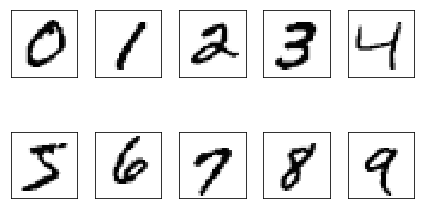

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Lets look at what different samples of the same digit looks like. You can change the label to look at other examples.

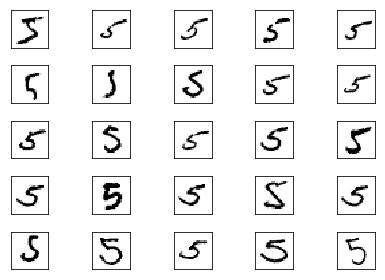

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 5][i].reshape(28, 28) # change the label to look at other digits
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

### Q1. Evaluate several examples of the digits. Name three data-augmentation operations that make sense for this data set.

<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.
* Scale
* Color variation and Guassian noise
* Translation

## Multi-layer perceptron
In this section we are going to implement our own multi-layer perceptron, including backpropagation. Carefully read all the hints in the code. The supplementary file will elaborate more on the details of the algorithm.

In [5]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training samples per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    # the onehot function encodes labels into onehot representation e.g. with 3 labels, 0->[1,0,0], 1->[0,1,0], 2->[0,0,1]
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        # implement sigmoid function here
        
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]-> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out)+ self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        
        # calculate the cost 
        L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        
        # create dictionary to keep track of training scores
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        # convert y to one-hot encoding
        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
            
            # this for loop takes care of the batching process. Every iteration several samples are fed through the network in one go.
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # calculate error vector of the output layer: sigma_out, [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                
                # calculate derivative of the sigmoid activation function:
                # sigmoid_derivative_h, [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # Calculate the error term of the hidden layer: sigma_h, 
                #[n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)

                # Calculate the gradients of the weights in the hidden layer
                # [n_features, n_samples] dot [n_samples, n_hidden] -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)

                # calculate gradients of the biases in the hidden layer (freebee)
                grad_b_h = np.sum(sigma_h, axis=0)

                # Calculate the gradients of the weights in the output layer
                # [n_hidden, n_samples] dot [n_samples, n_classlabels] -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                # calculate the gradient of the biases in the output layer
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r' + '{}/{} | Cost: {:.1f} | Train/Valid Acc.: {:.2f}%/{:.2f}% '.format(i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

Lets initialize the network and feed it training and validation data (55000 samples are used for training, remaining 5000 samples are used for validation).
### Q2. Why do we define a validation set even though we already have a test set of unseen samples? Explain your answer.
<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.

A validation set is used for the model selection and tuning for the hyperparameters, which can minimize overfitting.

In [6]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=20, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

20/20 | Cost: 24327.8 | Train/Valid Acc.: 92.86%/93.14% 

Lets plot the cost and the training/validation accuracy for 20 epochs. We can see the cost is decreasing and accuracy of both the training and validation is going up.

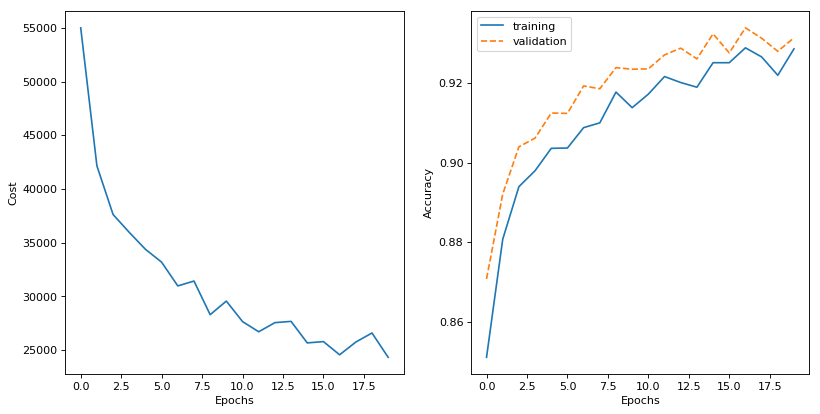

In [7]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()


## Q3. The validation accuracy is higher than the training accuracy. What does this say about the quality of the model?
<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.

From the graph, it can seen that the accurancy of validation is always slightly higher than the one of training. This means that the model is a little bit underfitting.

In [8]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.0001, 
                  epochs=200, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=123)

nn.fit(X_train=X_train[:50000], 
       y_train=y_train[:50000],
       X_valid=X_train[50000:],
       y_valid=y_train[50000:])

200/200 | Cost: 14567.8 | Train/Valid Acc.: 95.98%/95.81% 

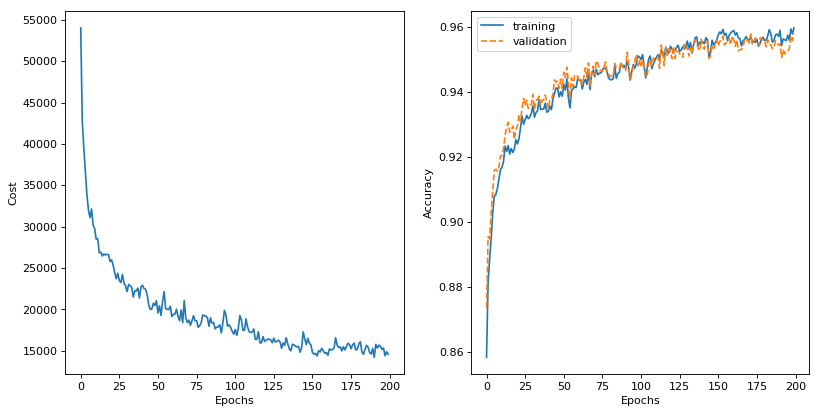

In [9]:
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,2,1)
ax.plot(range(nn.epochs), nn.eval_['cost'])
ax.set_ylabel('Cost')
ax.set_xlabel('Epochs')

ax = plt.subplot(1,2,2)
ax.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
ax.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

## Q4. The neural network is getting pretty good results on the data. How would you improve on the results further?

<span style="color:red">''' Write down the answer in the cell markdown here (doubleclick the text)  '''</span>.

The epochs could be increased even more and a better learning rate could be used to improve the results even further. Another option could be changing the percentage between the training set, validation set and test set. 